In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e9/sample_submission.csv
/kaggle/input/playground-series-s5e9/train.csv
/kaggle/input/playground-series-s5e9/test.csv


# Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


# 1. Exploratory Data Analysis (EDA)



Loading datasets...
--- Data Overview ---
Training data shape: (524164, 11)
Test data shape: (174722, 10)

First 5 rows of the training data:
   id  RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
0   0     0.603610      -7.636942      0.023500         0.000005   
1   1     0.639451     -16.267598      0.071520         0.444929   
2   2     0.514538     -15.953575      0.110715         0.173699   
3   3     0.734463      -1.357000      0.052965         0.001651   
4   4     0.532968     -13.056437      0.023500         0.068687   

   InstrumentalScore  LivePerformanceLikelihood  MoodScore  TrackDurationMs  \
0           0.000001                   0.051385   0.409866      290715.6450   
1           0.349414                   0.170522   0.651010      164519.5174   
2           0.453814                   0.029576   0.423865      174495.5667   
3           0.159717                   0.086366   0.278745      225567.4651   
4           0.000001                   0.331345   0.47

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


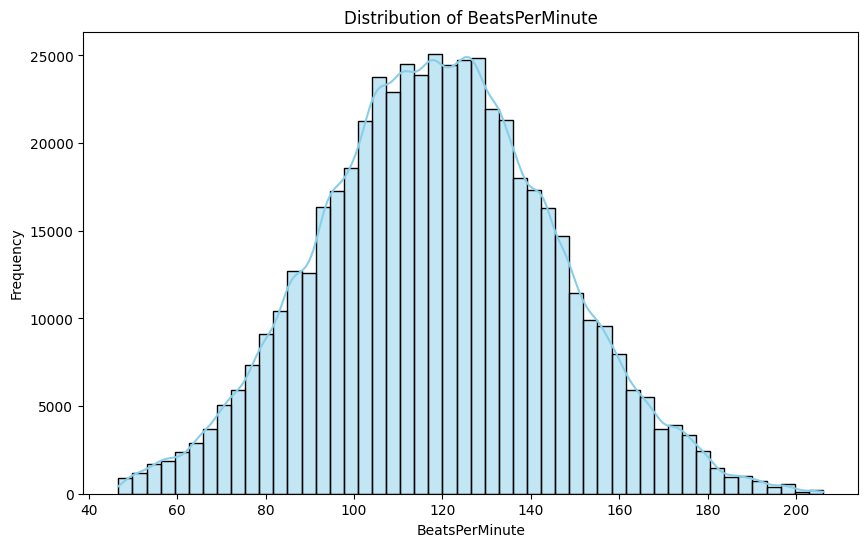

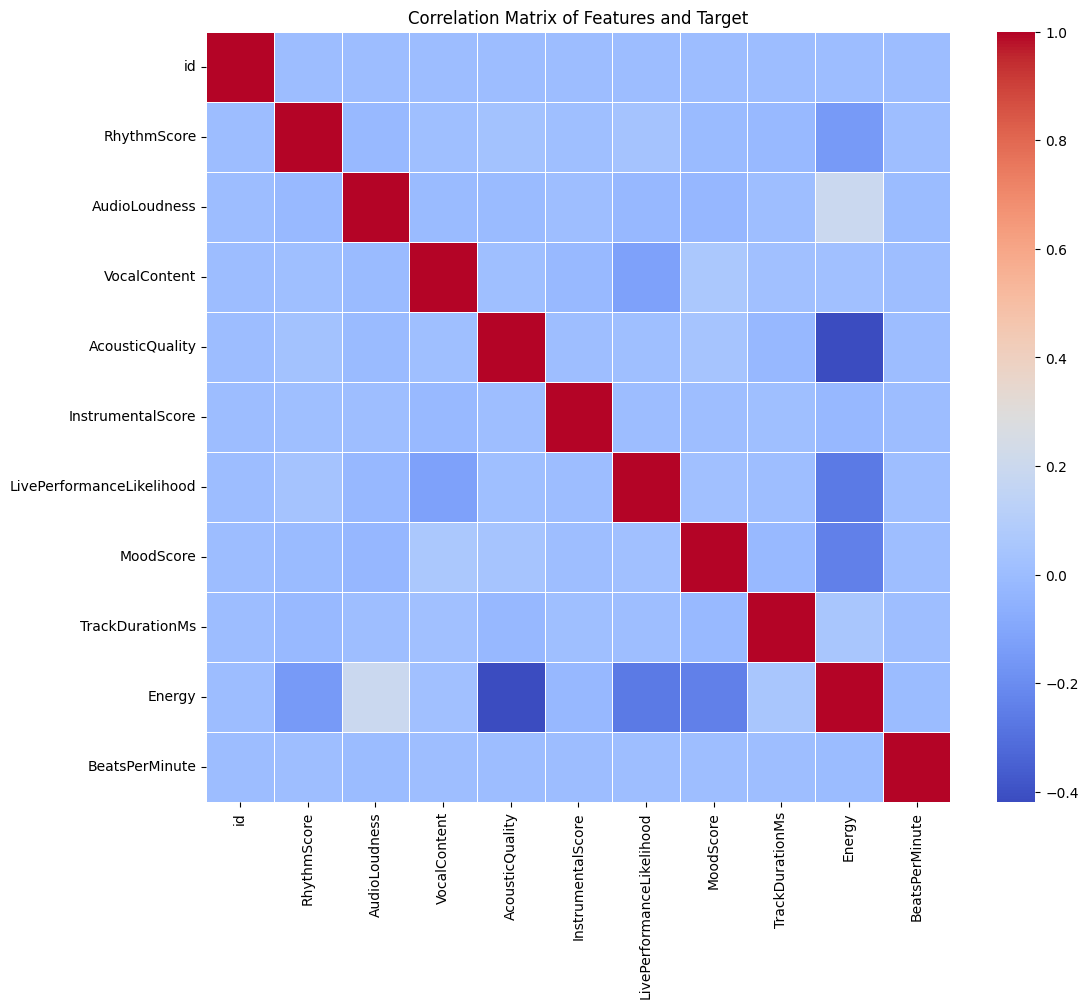

In [3]:
print("Loading datasets...")
try:
    train_df = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
    test_df = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")
    sample_submission_df = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")
except FileNotFoundError:
    print("Error: Ensure 'train.csv', 'test.csv', and 'sample_submission.csv' are in the same directory.")
    exit()

print("--- Data Overview ---")
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nFirst 5 rows of the training data:")
print(train_df.head())
print("\nTraining data info:")
train_df.info()

print("\nMissing values in training data:")
print(train_df.isnull().sum().sum())
print("\nMissing values in test data:")
print(test_df.isnull().sum().sum())

# Analyze the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(train_df['BeatsPerMinute'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of BeatsPerMinute')
plt.xlabel('BeatsPerMinute')
plt.ylabel('Frequency')
plt.show()

# Display a correlation matrix to understand feature relationships
plt.figure(figsize=(12, 10))
corr_matrix = train_df.corr(numeric_only=True)
sns.heatmap(corr_matrix, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features and Target')
plt.show()


# 2. Data Preprocessing & Feature Engineering


In [4]:
# Separate features and target variable
X = train_df.drop(['id', 'BeatsPerMinute'], axis=1)
y = train_df['BeatsPerMinute']
X_test = test_df.drop('id', axis=1)
test_ids = test_df['id']

print("\n--- Preprocessing & Feature Engineering ---")

# A simple example of creating a new feature: ratio of two features
# This demonstrates the concept; feel free to add more complex features.
if 'feature_0' in X.columns and 'feature_1' in X.columns:
    X['feature_ratio'] = X['feature_0'] / (X['feature_1'] + 1e-6) # Add small epsilon to avoid division by zero
    X_test['feature_ratio'] = X_test['feature_0'] / (X_test['feature_1'] + 1e-6)
    print("Added a new feature 'feature_ratio'.")
else:
    print("Skipping 'feature_ratio' creation as required features were not found.")

# Scaling features can sometimes help models, especially linear ones.
# While tree-based models like XGBoost are not sensitive to scaling, it's a good practice.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)
print("Features have been scaled using StandardScaler.")


--- Preprocessing & Feature Engineering ---
Skipping 'feature_ratio' creation as required features were not found.
Features have been scaled using StandardScaler.



# 3. Model Selection & Training


In [5]:
# Using XGBoost Regressor as the primary model.
# Start with default parameters to get a baseline.
print("\n--- Model Training ---")
model = xgb.XGBRegressor(objective='reg:squarederror',
                         eval_metric='mae', # MAE is the competition metric
                         n_estimators=100,
                         random_state=42,
                         n_jobs=-1)

print("Training baseline XGBoost model...")
model.fit(X_scaled, y)
print("Baseline model training complete.")


--- Model Training ---
Training baseline XGBoost model...
Baseline model training complete.



# 4. Hyperparameter Tuning & Cross-Validation


In [6]:
print("\n--- Hyperparameter Tuning with GridSearchCV ---")
# Define a smaller, manageable parameter grid for demonstration.
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# Use KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to find the best parameters.
# The scoring metric is negative mean absolute error because GridSearchCV maximizes the score.
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=kf,
                           n_jobs=-1,
                           verbose=1)

print("Running GridSearchCV...")
grid_search.fit(X_scaled, y)

print("\nBest hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)
print("\nBest MAE score (negated):", -grid_search.best_score_)

# Use the best model from the grid search for final predictions
best_model = grid_search.best_estimator_
print("\nFinal model is the best estimator from the grid search.")


--- Hyperparameter Tuning with GridSearchCV ---
Running GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best hyperparameters found by GridSearchCV:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Best MAE score (negated): 21.192948496730633

Final model is the best estimator from the grid search.



# 5. Prediction & Submission


In [7]:
print("\n--- Making Predictions and Creating Submission File ---")
predictions = best_model.predict(X_test_scaled)

# Ensure predictions are non-negative, as BPM cannot be negative.
predictions[predictions < 0] = 0

submission_df = pd.DataFrame({'id': test_ids, 'BeatsPerMinute': predictions})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")
print("\nFirst 5 rows of the submission file:")
print(submission_df.head())


--- Making Predictions and Creating Submission File ---
Submission file 'submission.csv' created successfully.

First 5 rows of the submission file:
       id  BeatsPerMinute
0  524164      119.196999
1  524165      118.660248
2  524166      119.444824
3  524167      119.337334
4  524168      119.311333
